# Titration Experiment

In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 't_subset_blueprint_2m_fix'
TITRATING_CELLTYPE = 't_reg'
TITRATING_CELLTYPE_ATLAS = 'immune_treg' # cell type name in atlas different
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
N_REPLICATES = 20 # number of replicates for each mixture
SEED = 888 # need to change for different experiment
TOTAL_READS_TO_SAMPLE = 2000000

# make sure the orders of the two list match
CELLTYPES = ['t_reg',
             't_effector', 
             't_naive',
             'Blueprint-B',
             'Blueprint-NK',
             'Blueprint-Mono',
             'Blueprint-Neutro']
ABRIDGED_NAMES = ['Treg', 'Teff', 'Tnaive', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

# TITRATION_LIST = [0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
#                   0.008, 0.006, 0.004, 0.002, 0.001, 0]


# # proportion of cells in real whole blood (sum to 1)
# WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
#                          'Blueprint-Mono':0.09,
#                          'Blueprint-Neutro':0.57,
#                          't_naive':0.16+0.07,
#                          'Blueprint-NK':0.05}
    

In [2]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [3]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [5]:
CELLTYPES = ['t_reg',
             't_effector', 
             't_naive',
             'Blueprint-B',
             'Blueprint-NK',
             'Blueprint-Mono',
             'Blueprint-Neutro']

ABRIDGED_NAMES = ['Treg', 'Teff', 'Tnaive', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

TITRATION_LIST = [0.20, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
                  0.008, 0.006, 0.004, 0.002, 0.001, 0] # % of total T-cells

# background cell type proportion (T is around 20%)
WHOLE_BLOOD_ABUNDANCE = {'B':0.06,
                         'Mono':0.09,
                         'Neutro':0.57,
                         'NK':0.05}

# background: % of total T-cells (multipy with 0.2)
WHOLE_BLOOD_ABUNDANCE_T = {'t_effector':0.20,
                           't_naive':0.80}

PROPORTIONS = []
treg_titrating_proprotions = [] 
teff_titrating_proprotions = []
tnai_titrating_proprotions = []

for t, alpha in enumerate(TITRATION_LIST):  
    
    # T cell total to be 23 % 
    proportion_treg = 0.23 * alpha  # alpha is the titrating proportion
    proportion_teff = 0.23 * (1-alpha) * WHOLE_BLOOD_ABUNDANCE_T['t_effector'] 
    proportion_tnai = 0.23 * (1-alpha) * WHOLE_BLOOD_ABUNDANCE_T['t_naive'] 
    
    treg_titrating_proprotions.append(proportion_treg)
    teff_titrating_proprotions.append(proportion_teff)
    tnai_titrating_proprotions.append(proportion_tnai)
    
    proportion = [proportion_treg, 
                  proportion_teff, 
                  proportion_tnai,
                  WHOLE_BLOOD_ABUNDANCE['B'],
                  WHOLE_BLOOD_ABUNDANCE['NK'],
                  WHOLE_BLOOD_ABUNDANCE['Mono'],
                  WHOLE_BLOOD_ABUNDANCE['Neutro']]
    
    PROPORTIONS.append(proportion)


In [6]:
teff_titrating_proprotions

[0.036800000000000006,
 0.0391,
 0.041400000000000006,
 0.04232,
 0.04324,
 0.044160000000000005,
 0.04508000000000001,
 0.045540000000000004,
 0.045632000000000006,
 0.04572400000000001,
 0.045816,
 0.045908000000000004,
 0.045954,
 0.046000000000000006]

In [7]:
sum(PROPORTIONS[5][0:3])

0.23000000000000004

## Create mixture

In [8]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/t_subset_mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [9]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: t_reg
----------> Loading cell type: t_effector
----------> Loading cell type: t_naive
----------> Loading cell type: Blueprint-B
----------> Loading cell type: Blueprint-NK
----------> Loading cell type: Blueprint-Mono
----------> Loading cell type: Blueprint-Neutro
>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.046000000000000006, 0.036800000000000006, 0.14720000000000003, 0.06, 0.05, 0.09, 0.57]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
----------> Creating mixture 3... 
----------> Creating mixture 4... 
----------> Creating mixture 5... 
----------> Creating mixture 6... 
----------> Creating mixture 7... 
----------> Creating mixture 8... 
----------> Creating mixture 9... 
----------> Creating mixture 10... 
----------> Creating mixture 11... 
----------> Creating mixture 12... 
----------> Creating mixture 13... 
----------> 

## Compute score matrix

In [10]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [11]:
cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [12]:
%%time
ridxs = ~cpg_map['cpg_index_hg38'].isna()
hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

CPU times: user 16.7 s, sys: 24 s, total: 40.7 s
Wall time: 40.7 s


In [13]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

region_df['region_cpg_index_max'] -= 1
region_df.sort_values('region_cpg_index_min', inplace=True)
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [14]:
ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [15]:
cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
ridxs = (cg_count_hg19==cg_count_hg38)
ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1657, 1657)

In [16]:
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [17]:
### Restrict to immune regions
#-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# BLUEPRINT immune regions
ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.t_subset.atlas.tsv.gz'
atlas = pd.read_csv(ATLAS_PATH, sep='\t')
subset_region_set = set(atlas.region_id)
#-----------------------------------------------------------------------------

# filter regions down to regions of interest
region_df = region_df[region_df['region_id'].isin(subset_region_set)]
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id,region_cpg_index_min_hg38,region_cpg_index_max_hg38
0,chr1,1114771,1114971,20117,20129,Immune_Broad_B-chr1:1114772-1114971,21119,21131
1,chr1,1157450,1157720,21684,21703,Immune_Broad_NK-chr1:1157451-1157720,22686,22705
2,chr1,1157879,1158277,21710,21726,Immune_Broad_NK-chr1:1157880-1158277,22712,22728
8,chr1,2515277,2515485,69489,69494,Immune_Refined_CD4_Reg-chr1:2515278-2515485,70616,70621
14,chr1,6341182,6341377,140667,140681,Immune_Broad_Eosi-chr1:6341183-6341377,142368,142382


In [ ]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       region_df = region_df, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E046TREG_E0368TEFF_E1472TNAIVE_E06B_E05NK_E09MONO_E57NEUTRO
--------> Computing score matrix for mix0_seed512070
--------> Computing score matrix for mix1_seed150400
--------> Computing score matrix for mix2_seed53691
--------> Computing score matrix for mix3_seed241485
--------> Computing score matrix for mix4_seed611692
--------> Computing score matrix for mix5_seed102110
--------> Computing score matrix for mix6_seed427511
--------> Computing score matrix for mix7_seed816474
--------> Computing score matrix for mix8_seed924679
--------> Computing score matrix for mix9_seed511217
--------> Computing score matrix for mix10_seed770508
--------> Computing score matrix for mix11_seed333624
--------> Computing score matrix for mix12_seed553125
--------> Computing score matrix for mix13_seed550436
--------> Computing score matrix for mix14_seed784522
--------> Computing score matrix for mix15_seed160495
--------> Computing score matrix for mix16

## Deconvolution

In [167]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.t_subset_same.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.t_subset_same.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [168]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(324, 11)

In [169]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 4.62 s, sys: 8.88 ms, total: 4.63 s
Wall time: 4.63 s


In [170]:
deconvolution_nnls[12]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ref_celltype,,,,,,,,,,,,,,,,,,,,
immune_b,0.058288,0.057560,0.059385,0.061941,0.055910,0.060138,0.057583,0.056477,0.062684,0.058222,0.061219,0.057451,0.058127,0.059958,0.058907,0.060255,0.055889,0.060440,0.059589,0.058911
immune_t_naive,0.186899,0.175992,0.179261,0.177572,0.165424,0.179157,0.179170,0.180003,0.181336,0.170832,0.184788,0.172437,0.181349,0.179188,0.185820,0.176458,0.175241,0.179804,0.166388,0.177429
immune_t_effector,0.041502,0.045944,0.050218,0.042243,0.048160,0.046984,0.039215,0.040055,0.041081,0.049131,0.039232,0.051571,0.041282,0.046272,0.038262,0.046990,0.047246,0.037144,0.052707,0.039483
immune_treg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
immune_nk,0.047960,0.044444,0.047340,0.048235,0.048371,0.050064,0.049455,0.046377,0.046833,0.047246,0.047987,0.048011,0.048707,0.047647,0.049102,0.046505,0.047102,0.046537,0.046246,0.048109
immune_mono,0.093700,0.102407,0.097731,0.103840,0.102224,0.089807,0.094564,0.102842,0.106603,0.099744,0.103093,0.103104,0.106118,0.098585,0.095627,0.095754,0.098760,0.097148,0.095140,0.097647
immune_eosi,0.000000,0.000806,0.000325,0.001602,0.000078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000397,0.000000,0.000282,0.000000,0.000442,0.001016,0.000000,0.001361,0.000925,0.000000
immune_neutro,0.559832,0.556634,0.559089,0.559121,0.554110,0.562500,0.555684,0.550574,0.557346,0.551380,0.551590,0.556503,0.564155,0.553915,0.560177,0.561924,0.560174,0.557854,0.556857,0.559784
immune_eryth,0.000804,0.000856,0.000000,0.000716,0.002050,0.000568,0.000317,0.000000,0.000000,0.000000,0.000138,0.000785,0.000000,0.000000,0.001311,0.001914,0.000190,0.000396,0.001845,0.000000


In [171]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

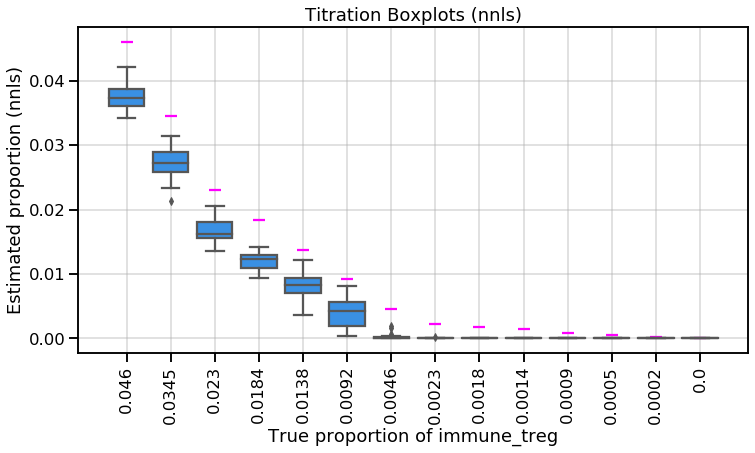

In [172]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=[round(x, 4) for x in treg_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

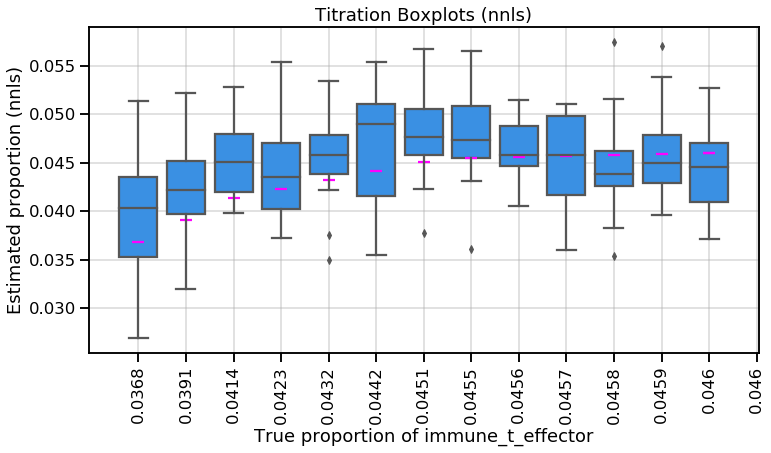

In [173]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_t_effector',
                      true_proportions=[round(x, 4) for x in teff_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

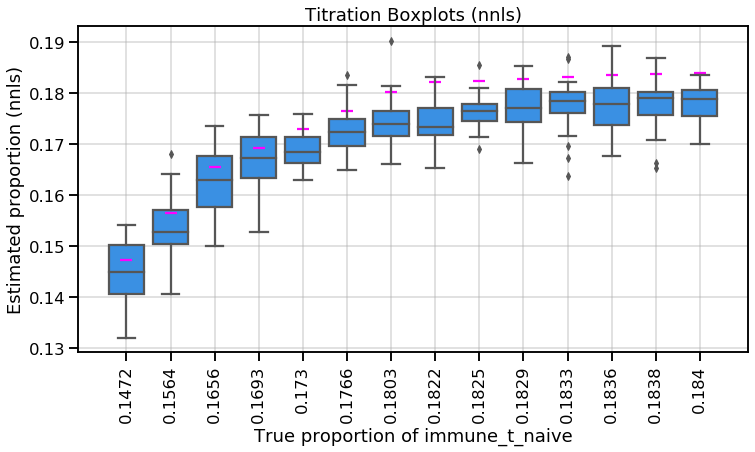

In [174]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_t_naive',
                      true_proportions=[round(x, 4) for x in tnai_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

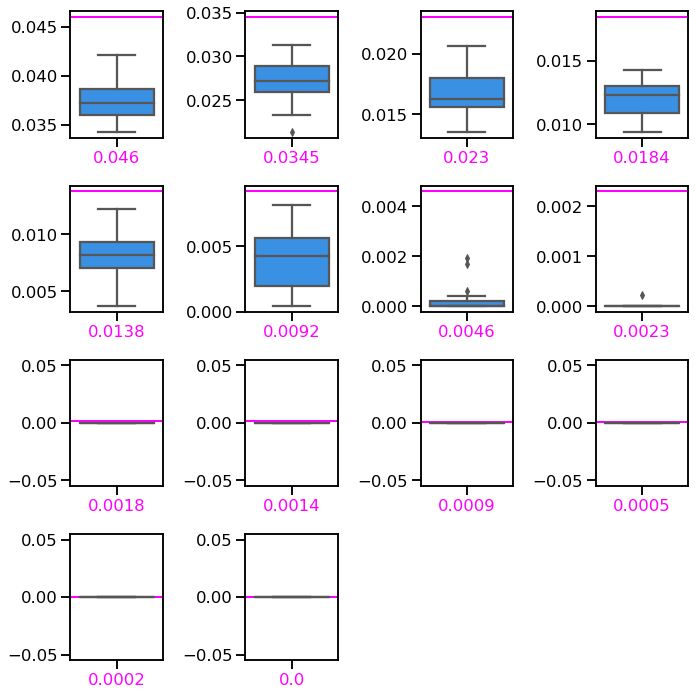

In [175]:
dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=[round(x, 4) for x in treg_titrating_proprotions],
                      deconvolution_method_name='nnls')

In [166]:
# spot check one mixture replicate